# Convolutional Neural Network (CNN)
- Zwei verschiedene Arten von Convolutional Neural Networks (CNNs) werden in diesem Notebook implementiert.
    - CNN mit kausaler Faltung, d.h. die Ausgabe/Vorhersage hängt nur von der Vergangenheit ab.
    - CNN mit normaler Faltung, d.h. die Ausgabe/Vorhersage hängt von der Zukunft und der Vergangenheit ab.

- Es besteht die Möglichkeit, die Audio-Daten in Mel-Spektrogramme oder in MFCCs umzuwandeln.

Bei der Erstellung des Codes wurde sich an den folgenden Quellen orientiert:
- https://medium.com/@oluyaled/audio-classification-using-deep-learning-and-tensorflow-a-step-by-step-guide-5327467ee9ab
- https://www.tensorflow.org/tutorials/images/cnn
- https://wandb.ai/mostafaibrahim17/ml-articles/reports/An-Introduction-to-Audio-Classification-with-Keras--Vmlldzo0MDQzNDUy

# 1. Schritt: Audio-Dateien laden und in Spektrogramme umwandeln

In [1]:
import sys

import numpy as np
import os
sys.path.append(os.path.abspath(".."))

from feature_extraction import get_mfccs_from_coswara_audio_files
from feature_extraction import get_mfccs_from_virufy_audio_files
from feature_extraction import get_valid_coswara_folder_names

labels_dict = {0: "neg", 1: "pos"}

labels, mfccs = [], []

p_folder_names, n_folder_names = get_valid_coswara_folder_names()

# Umwandlung der Coswara-Audio-Dateien in MFCCss
p_coswara_mfccs, p_coswara_labels = get_mfccs_from_coswara_audio_files(
    p_folder_names, is_positive=True
)

n_coswara_mfccs, n_coswara_labels = get_mfccs_from_coswara_audio_files(
    n_folder_names, is_positive=False
)

# Umwandlung der Virufy-Audio-Dateien in MFCCs
p_virufy_mfccs, p_virufy_labels = get_mfccs_from_virufy_audio_files(
    is_positive=True
)
n_virufy_mfccs, n_virufy_labels = get_mfccs_from_virufy_audio_files(
    is_positive=False
)

mfcc = np.concatenate(
    (p_coswara_mfccs, n_coswara_mfccs, p_virufy_mfccs, n_virufy_mfccs)
)

labels = np.concatenate(
    (p_coswara_labels, n_coswara_labels, p_virufy_labels, n_virufy_labels)
)

mels = np.array(mfcc, dtype=np.float32)

labels = np.array(labels, dtype=np.int32)

print(len(mfcc), len(labels))


/Users/paula/opt/anaconda3/lib/python3.9/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
2025-01-21 20:08:54.311868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4470 4470


# 2. Schritt: Aufteilen der Daten in Trainings- und Testdaten

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Labels in One-Hot-Encoding umwandeln
labels = to_categorical(labels, num_classes=len(labels_dict))

# Train-Test-Split durchführen
mel_train, mel_test, labels_train, labels_test = train_test_split(
    mels, labels, test_size=0.2, random_state=42
)
mel_train = mels
labels_train = labels

# print(
#     f"""mel_train.shape: {mel_train.shape},
#     labels_train.shape: {labels_train.shape}"""
# )
# print(
#     f"""mel_test.shape: {mel_test.shape},
#     labels_test.shape: {labels_test.shape}"""
# )


# 3. Schritt: CNN-Modelle erstellen

In [3]:
# Konfiguration des Trainingsprozesses
BATCH_SIZE = 64
EPOCHS = 20
ACTIVATION_1 = "relu"
ACTIVATION_2 = "softmax"
METRIC = "accuracy"
LOSS = "categorical_crossentropy"
OPTIMIZER = "adam"


In [4]:
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.models import Sequential


def build_cnn(*, include_future: bool) -> Sequential:
    """Erstellt ein CNN-Modell, das auf den Mel-Spektrogrammen trainiert wird.

    :param include_future: Boolean, ob die Zukunft berücksichtigt werden soll
    :return: CNN-Modell (TensorFlow Sequential Model)
    """
    # CNN-Modell wird definiert
    model = Sequential()

    # Eingabeform: (128, 128, 1)
    input_shape = mel_train[0].shape

    padding_value = "valid"
    if not include_future:
        padding_value = "causal"

    # Convolutional-Schicht
    # 32 Filter (Merkmale), Kernelgröße 3, Aktivierungsfunktion ReLU
    model.add(
        Conv1D(
            32,
            kernel_size=3,
            activation=ACTIVATION_1,
            input_shape=(input_shape),
            padding=padding_value,
        )
    )

    # MaxPooling-Schicht
    # Reduziert die Größe der Ausgabe, indem es die höchsten Werte
    # aus 2 Blöcken auswählt
    model.add(MaxPooling1D(pool_size=2))

    # Convolutional-Schicht
    # 64 Filter (Merkmale), Kernelgröße 3, Aktivierungsfunktion ReLU
    model.add(
        Conv1D(
            64, kernel_size=3, activation=ACTIVATION_1, padding=padding_value
        )
    )

    # Wandelt die mehrdimensionale Ausgabe in einen Vektor um
    model.add(Flatten())

    # Dense-Schicht
    # 64 Neuronen, Aktivierungsfunktion ReLU (Führt Klassifizierungslogik durch)
    model.add(Dense(64, activation=ACTIVATION_1))

    # Dropout-Schicht
    # Ausgabeschicht mit einer Neuronanzahl, die der
    # Anzahl der Klassen (2 für positiv/negativ) entspricht.
    model.add(Dense(len(labels_dict), activation=ACTIVATION_2))
    # model.summary()
    return model


# 3.1. Schritt: CNN mit kausaler Faltung

In [5]:
causal_model = build_cnn(include_future=False)


# 3.2. Schritt: CNN mit normaler Faltung

In [6]:
model = build_cnn(include_future=True)


# 4. Modell kompilieren

In [7]:
# Modelle werden für das Training vorbereitet
# Optimierungsalgorithmus: Adam (Optimierungsalgorithmus) (Wie werden die
# Gewichte angepasst)
# Verlustfunktion: Categorical Crossentropy (Wie werden die Fehler berechnet)
# Metrik: Genauigkeit (Welche Metrik wird zur Bewertung des Modells verwendet)
causal_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[METRIC])
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[METRIC])


#  5 Schritt: W&B Project initialisieren und Modell trainieren

In [8]:
def train_and_wandbLog(
    model, mel_train, labels_train, mel_test, labels_test, *, with_future: bool
):
    """Trainiert das Modell und loggt die Metriken in Weights & Biases.

    :param model: Modell, das trainiert werden soll
    :param mel_train: Trainingsdaten (Mel-Spektrogramme oder MFCCs)
    :param labels_train: Trainingsdaten (Labels)
    :param mel_test: Testdaten (Mel-Spektrogramme oder MFCCs)
    :param labels_test: Testdaten (Labels)
    :param with_future: Boolean, ob die Zukunft berücksichtigt werden soll
    :return: History-Objekt des Trainingsprozesses
    """
    import wandb

    wandb.init(
        project="cnn_covid_audio_classification",
        config={
            "batch_size": BATCH_SIZE,
            "epochs": EPOCHS,
            "architecture": "CNN",
            "dataset": "coswara + virufy",
            "activation_1": ACTIVATION_1,
            "activation_2": ACTIVATION_2,
            "metric": METRIC,
            "loss": LOSS,
            "optimizer": OPTIMIZER,
        },
    )

    # WandB Run Name setzen
    FUTURE = "FUTURE" if with_future else "NO_FUTURE"
    wandb.run.name = f"{FUTURE}_batch_size_{BATCH_SIZE}_epochs_{EPOCHS}_activation_1_{ACTIVATION_1}_activation_2_{ACTIVATION_2}_metric_{METRIC}_loss_{LOSS}_optimizer_{OPTIMIZER}"

    history = model.fit(
        mel_train,
        labels_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(mel_test, labels_test),
        callbacks=[
            wandb.keras.WandbMetricsLogger(log_freq=5),
            wandb.keras.WandbModelCheckpoint("models"),
        ],
    )

    wandb.finish()
    return history


In [9]:
# Training des Modells
history = train_and_wandbLog(
    model, mel_train, labels_train, mel_test, labels_test, with_future=True
)
causal_history = train_and_wandbLog(
    causal_model,
    mel_train,
    labels_train,
    mel_test,
    labels_test,
    with_future=False,
)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: paula-schwalm (paula-schwalm-technische-hochschule-mittelhessen-thm). Use `wandb login --relogin` to force relogin


Epoch 1/20
70/70 [==============================] - ETA: 0s - loss: 1.6810 - accuracy: 0.6376

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


70/70 [==============================] - 2s 21ms/step - loss: 1.6810 - accuracy: 0.6376 - val_loss: 0.6294 - val_accuracy: 0.6779
Epoch 2/20
62/70 [=========================>....] - ETA: 0s - loss: 0.6184 - accuracy: 0.6923

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 16ms/step - loss: 0.6162 - accuracy: 0.6951 - val_loss: 0.6357 - val_accuracy: 0.6779
Epoch 3/20
68/70 [============================>.] - ETA: 0s - loss: 0.6202 - accuracy: 0.6921

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 14ms/step - loss: 0.6178 - accuracy: 0.6951 - val_loss: 0.6281 - val_accuracy: 0.6779
Epoch 4/20
68/70 [============================>.] - ETA: 0s - loss: 0.6177 - accuracy: 0.6946

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 14ms/step - loss: 0.6172 - accuracy: 0.6951 - val_loss: 0.6303 - val_accuracy: 0.6779
Epoch 5/20
64/70 [==========================>...] - ETA: 0s - loss: 0.6193 - accuracy: 0.6912

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 17ms/step - loss: 0.6166 - accuracy: 0.6951 - val_loss: 0.6279 - val_accuracy: 0.6779
Epoch 6/20
69/70 [============================>.] - ETA: 0s - loss: 0.6175 - accuracy: 0.6959

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 14ms/step - loss: 0.6180 - accuracy: 0.6951 - val_loss: 0.6274 - val_accuracy: 0.6779
Epoch 7/20
66/70 [===========================>..] - ETA: 0s - loss: 0.6153 - accuracy: 0.6953

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 14ms/step - loss: 0.6155 - accuracy: 0.6951 - val_loss: 0.6277 - val_accuracy: 0.6779
Epoch 8/20
67/70 [===========================>..] - ETA: 0s - loss: 0.6149 - accuracy: 0.6957

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 14ms/step - loss: 0.6153 - accuracy: 0.6951 - val_loss: 0.6273 - val_accuracy: 0.6779
Epoch 9/20
64/70 [==========================>...] - ETA: 0s - loss: 0.6191 - accuracy: 0.6943

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 15ms/step - loss: 0.6184 - accuracy: 0.6951 - val_loss: 0.6280 - val_accuracy: 0.6779
Epoch 10/20
65/70 [==========================>...] - ETA: 0s - loss: 0.6158 - accuracy: 0.6959

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 14ms/step - loss: 0.6163 - accuracy: 0.6951 - val_loss: 0.6275 - val_accuracy: 0.6779
Epoch 11/20
69/70 [============================>.] - ETA: 0s - loss: 0.6161 - accuracy: 0.6961

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 14ms/step - loss: 0.6170 - accuracy: 0.6951 - val_loss: 0.6284 - val_accuracy: 0.6779
Epoch 12/20
65/70 [==========================>...] - ETA: 0s - loss: 0.6165 - accuracy: 0.6947

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 15ms/step - loss: 0.6162 - accuracy: 0.6951 - val_loss: 0.6274 - val_accuracy: 0.6779
Epoch 13/20
65/70 [==========================>...] - ETA: 0s - loss: 0.6175 - accuracy: 0.6933

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 17ms/step - loss: 0.6157 - accuracy: 0.6951 - val_loss: 0.6335 - val_accuracy: 0.6779
Epoch 14/20
64/70 [==========================>...] - ETA: 0s - loss: 0.6183 - accuracy: 0.6934

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 15ms/step - loss: 0.6168 - accuracy: 0.6951 - val_loss: 0.6296 - val_accuracy: 0.6779
Epoch 15/20
66/70 [===========================>..] - ETA: 0s - loss: 0.6146 - accuracy: 0.6967

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 15ms/step - loss: 0.6163 - accuracy: 0.6951 - val_loss: 0.6273 - val_accuracy: 0.6779
Epoch 16/20
66/70 [===========================>..] - ETA: 0s - loss: 0.6148 - accuracy: 0.6965

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 15ms/step - loss: 0.6159 - accuracy: 0.6951 - val_loss: 0.6273 - val_accuracy: 0.6779
Epoch 17/20
62/70 [=========================>....] - ETA: 0s - loss: 0.6163 - accuracy: 0.6958

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 15ms/step - loss: 0.6167 - accuracy: 0.6951 - val_loss: 0.6282 - val_accuracy: 0.6779
Epoch 18/20
69/70 [============================>.] - ETA: 0s - loss: 0.6170 - accuracy: 0.6936

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 14ms/step - loss: 0.6158 - accuracy: 0.6951 - val_loss: 0.6295 - val_accuracy: 0.6779
Epoch 19/20
58/70 [=======================>......] - ETA: 0s - loss: 0.6174 - accuracy: 0.6932

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 14ms/step - loss: 0.6158 - accuracy: 0.6951 - val_loss: 0.6273 - val_accuracy: 0.6779
Epoch 20/20
70/70 [==============================] - ETA: 0s - loss: 0.6156 - accuracy: 0.6951

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 15ms/step - loss: 0.6156 - accuracy: 0.6951 - val_loss: 0.6289 - val_accuracy: 0.6779


batch/accuracy,▄▆▆▇█▇▇▇▇▇▇▇▇▆▁▇▆▆▇▇▇▇▄▇▇▇▇▇▆▆▇▇▇▇▇▇▇▇▆▆
batch/batch_step,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁███████████████████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,▃█▂▄▂▁▁▁▂▁▂▁▆▃▁▁▂▃▁▂
batch/accuracy,0.69579


Epoch 1/20
60/70 [========================>.....] - ETA: 0s - loss: 1.8828 - accuracy: 0.6552

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 2s 20ms/step - loss: 1.7043 - accuracy: 0.6611 - val_loss: 0.6283 - val_accuracy: 0.6779
Epoch 2/20
70/70 [==============================] - ETA: 0s - loss: 0.6166 - accuracy: 0.6951

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 16ms/step - loss: 0.6166 - accuracy: 0.6951 - val_loss: 0.6325 - val_accuracy: 0.6779
Epoch 3/20
64/70 [==========================>...] - ETA: 0s - loss: 0.6211 - accuracy: 0.6936

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 15ms/step - loss: 0.6197 - accuracy: 0.6951 - val_loss: 0.6277 - val_accuracy: 0.6779
Epoch 4/20
64/70 [==========================>...] - ETA: 0s - loss: 0.6137 - accuracy: 0.7004

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 15ms/step - loss: 0.6182 - accuracy: 0.6951 - val_loss: 0.6411 - val_accuracy: 0.6779
Epoch 5/20
59/70 [========================>.....] - ETA: 0s - loss: 0.6216 - accuracy: 0.6904

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 15ms/step - loss: 0.6174 - accuracy: 0.6951 - val_loss: 0.6350 - val_accuracy: 0.6779
Epoch 6/20
66/70 [===========================>..] - ETA: 0s - loss: 0.6153 - accuracy: 0.6972

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 14ms/step - loss: 0.6169 - accuracy: 0.6951 - val_loss: 0.6272 - val_accuracy: 0.6779
Epoch 7/20
65/70 [==========================>...] - ETA: 0s - loss: 0.6171 - accuracy: 0.6940

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 14ms/step - loss: 0.6162 - accuracy: 0.6951 - val_loss: 0.6300 - val_accuracy: 0.6779
Epoch 8/20
66/70 [===========================>..] - ETA: 0s - loss: 0.6155 - accuracy: 0.6953

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 16ms/step - loss: 0.6157 - accuracy: 0.6951 - val_loss: 0.6295 - val_accuracy: 0.6779
Epoch 9/20
67/70 [===========================>..] - ETA: 0s - loss: 0.6202 - accuracy: 0.6933

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 15ms/step - loss: 0.6184 - accuracy: 0.6951 - val_loss: 0.6306 - val_accuracy: 0.6779
Epoch 10/20
63/70 [==========================>...] - ETA: 0s - loss: 0.6177 - accuracy: 0.6939

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 15ms/step - loss: 0.6176 - accuracy: 0.6951 - val_loss: 0.6273 - val_accuracy: 0.6779
Epoch 11/20
65/70 [==========================>...] - ETA: 0s - loss: 0.6163 - accuracy: 0.6945

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 15ms/step - loss: 0.6157 - accuracy: 0.6951 - val_loss: 0.6311 - val_accuracy: 0.6779
Epoch 12/20
65/70 [==========================>...] - ETA: 0s - loss: 0.6168 - accuracy: 0.6935

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 14ms/step - loss: 0.6156 - accuracy: 0.6951 - val_loss: 0.6272 - val_accuracy: 0.6779
Epoch 13/20
61/70 [=========================>....] - ETA: 0s - loss: 0.6116 - accuracy: 0.6995

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 16ms/step - loss: 0.6152 - accuracy: 0.6951 - val_loss: 0.6272 - val_accuracy: 0.6779
Epoch 14/20
58/70 [=======================>......] - ETA: 0s - loss: 0.6348 - accuracy: 0.6843

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 16ms/step - loss: 0.6279 - accuracy: 0.6902 - val_loss: 0.6357 - val_accuracy: 0.6779
Epoch 15/20
63/70 [==========================>...] - ETA: 0s - loss: 0.6193 - accuracy: 0.6935

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 16ms/step - loss: 0.6181 - accuracy: 0.6951 - val_loss: 0.6273 - val_accuracy: 0.6779
Epoch 16/20
62/70 [=========================>....] - ETA: 0s - loss: 0.6126 - accuracy: 0.6996

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 15ms/step - loss: 0.6166 - accuracy: 0.6951 - val_loss: 0.6273 - val_accuracy: 0.6779
Epoch 17/20
68/70 [============================>.] - ETA: 0s - loss: 0.6185 - accuracy: 0.6928

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 20ms/step - loss: 0.6170 - accuracy: 0.6951 - val_loss: 0.6289 - val_accuracy: 0.6779
Epoch 18/20
66/70 [===========================>..] - ETA: 0s - loss: 0.6178 - accuracy: 0.6932

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 15ms/step - loss: 0.6173 - accuracy: 0.6951 - val_loss: 0.6308 - val_accuracy: 0.6779
Epoch 19/20
63/70 [==========================>...] - ETA: 0s - loss: 0.6159 - accuracy: 0.6974

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 14ms/step - loss: 0.6176 - accuracy: 0.6951 - val_loss: 0.6283 - val_accuracy: 0.6779
Epoch 20/20
64/70 [==========================>...] - ETA: 0s - loss: 0.6136 - accuracy: 0.6978

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


70/70 [==============================] - 1s 15ms/step - loss: 0.6161 - accuracy: 0.6951 - val_loss: 0.6273 - val_accuracy: 0.6779


batch/accuracy,▁▃▄▄▆▆▆▆▇▇▆▅▆▆▇▆▇▇▇▆█▆▇▆▆▇▅▅▇▇█▆▆▇▇▇▆▆▇▆
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,▂█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁████████████▇██████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,▂▄▁█▅▁▂▂▃▁▃▁▁▅▁▁▂▃▂▁
batch/accuracy,0.69602


# 6. Evaluation

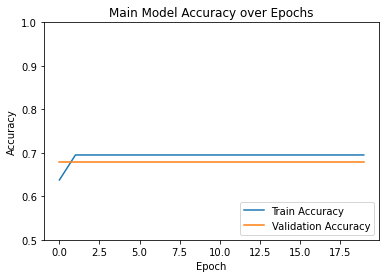

28/28 - 0s - loss: 0.6289 - accuracy: 0.6779 - 64ms/epoch - 2ms/step
Main Model Test Accuracy: 0.6779
Main Model Test Loss: 0.6289


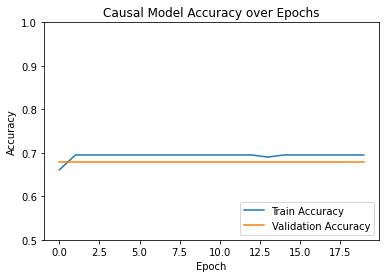

28/28 - 0s - loss: 0.6273 - accuracy: 0.6779 - 71ms/epoch - 3ms/step
Causal Model Test Accuracy: 0.6779
Causal Model Test Loss: 0.6273


In [10]:
import matplotlib.pyplot as plt


def plot_accuracy_and_evaluate(
    model: Sequential,
    history: Sequential,
    mel_test: dict,
    labels_test: dict,
    model_name: str = "Model",
) -> None:
    """Plottet die Trainings- und Validierungsgenauigkeit.

    :param model: Modell, das evaluiert werden soll
    :param history: Trainingshistorie des Modells
    :param mel_test: Testdaten (Mel-Spektrogramme)
    :param labels_test: Testlabels
    :param model_name: Name des Modells
    """
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim([0.5, 1])
    plt.title(f"{model_name} Accuracy over Epochs")
    plt.legend(loc="lower right")
    plt.show()

    test_loss, test_acc = model.evaluate(mel_test, labels_test, verbose=2)
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")
    print(f"{model_name} Test Loss: {test_loss:.4f}")


# Beispielaufruf für das Standardmodell
plot_accuracy_and_evaluate(
    model, history, mel_test, labels_test, model_name="Main Model"
)

# Beispielaufruf für das Causal Modell
plot_accuracy_and_evaluate(
    causal_model,
    causal_history,
    mel_test,
    labels_test,
    model_name="Causal Model",
)
